In [1]:
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from typing import Callable, Optional
from probe_model import DRCProbe
from create_probe_dataset import ProbingDataset
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
import thinker
#import thinker.viz_utils as viz
import thinker.util as util
import gym
import gym_sokoban
import torch.nn.functional as F
import pandas as pd
import numpy as np

/home/tom/mlmi/dissertation/working_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-01 18:07:53,639	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.



In [2]:
val_dataset = torch.load("./data/val_data.pt")

In [3]:
val_dataset[0].keys()

dict_keys(['adj_walls', 'adj_boxnotontar', 'adj_boxontar', 'adj_tar', 'num_boxnotontar', 'agent_loc', 'box_loc', 'action', 'value', 'board_state', 'hidden_states', 'board_num', 'reward', 'action_ahead_1', 'action_ahead_2', 'action_ahead_3', 'reward_ahead_1', 'reward_ahead_2', 'reward_ahead_3', 'value_ahead_1', 'value_ahead_2', 'value_ahead_3', 'agent_loc_ahead_1', 'agent_loc_ahead_2', 'agent_loc_ahead_3', 'action_traj_1', 'action_traj_2', 'action_traj_3', 'reward_traj_1', 'reward_traj_2', 'reward_traj_3', 'value_traj_1', 'value_traj_2', 'value_traj_3', 'num_boxnotontar_until_change', 'action_until_change', 'steps_remaining', 'num_boxnotontar_until_change_lessthan_1', 'num_boxnotontar_until_change_lessthan_3', 'num_boxnotontar_until_change_lessthan_5', 'steps_remaining_lessthan_1', 'steps_remaining_lessthan_3', 'steps_remaining_lessthan_5', 'action_until_change_lessthan_0'])

In [55]:
results = pd.read_csv("./results/action_traj_1_multi.csv")

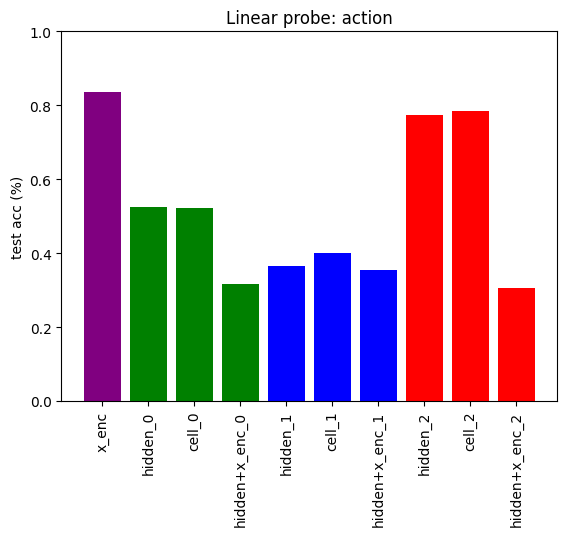

In [62]:
feature = "action"
results = pd.read_csv(f"./results/{feature}_multi.csv")
test_accs = list(results.iloc[-1,1:].values[-1:]) + list(results.iloc[-1,1:].values[:3]) + list(results.iloc[-1,1:].values[4:6]) + list(results.iloc[-1,1:].values[7:-1])
labs = results.keys().to_list()[1:][:3] + results.keys().to_list()[1:][4:6] + results.keys().to_list()[1:][7:]
fig, ax = plt.subplots()
cols = ["purple"] + ["green"]*3 + ["blue"]*3 + ["red"]*3
labs = ["x_enc", "hidden_0", "cell_0", "hidden+x_enc_0", "hidden_1", "cell_1", "hidden+x_enc_1", "hidden_2", "cell_2", "hidden+x_enc_2"]
ax.bar(labs, test_accs, color=cols)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylim(0,1)
ax.set_ylabel("test acc (%)")
ax.set_title(f"Linear probe: {feature}")
plt.show()

In [46]:
labs

['x_enc',
 'hidden',
 'cell',
 'hidden+x_enc',
 'hidden',
 'cell',
 'hidden+x_enc',
 'hidden',
 'cell',
 'hidden+x_enc']

In [ ]:
test_accs = 

In [12]:
results.iloc[1:,-1].values

array([0.6824817518248175, 0.8868613138686131, 1.0, 0.0145985401459854,
       0.0255474452554744, 0.0291970802919708, 0.0510948905109489,
       0.0145985401459854, 0.0437956204379562, 0.0547445255474452,
       0.0620437956204379, 0.0437956204379562, 0.0182481751824817,
       0.0437956204379562, 0.0291970802919708, 0.0620437956204379,
       0.0401459854014598, 0.0291970802919708, 0.1532846715328467,
       0.0437956204379562, 0.0364963503649635, 0.0437956204379562,
       0.0620437956204379], dtype=object)

In [ ]:
h = 